    
# Bjerksund-Stensland Closed American Option Pricing Model

The goal is to replicate the approximations from 'Closed Form Valuation of American Options' Table 1. 

In [227]:
import numpy as np
import scipy.stats as si
from scipy.stats import multivariate_normal as mvn
import pandas as pd

In [228]:
###############
#Phi functions#
###############

def expec(S,T,sigma,b,Y,H,X, rf):
    """
    Phi function for flat-boundary implementation
    """
    lambdas= -rf + Y*b+0.5*Y*(Y-1)*(sigma)**2
    k = ((2*b)/(sigma**2)) + (2*Y-1)

    d1= - (np.log(S / H) + ( b + (Y- 0.5 )* sigma**2) * T) / (sigma * np.sqrt(T))
    Nd1 =si.norm.cdf(d1, 0.0, 1.0)

    d2= - (np.log(X**2 /(S* H)) + ( b + (Y- 0.5 )* sigma**2) * T) / (sigma * np.sqrt(T))
    Nd2 = si.norm.cdf(d2, 0.0, 1.0)
    
    expec=(np.exp(lambdas*T)*(S**Y))*(Nd1 - ((X/S)**k)*Nd2)
    return expec
   
def expec2(S,T,sigma,b,Y,H,X,x,t,rf):
    """
    Phi function for 2-step implementation
    """
    d1= - (np.log(S / x) + ( b + (Y- 0.5 )* sigma**2) * t) / (sigma * np.sqrt(t))
    d2= - (np.log(X**2 / (S*x)) + ( b + (Y- 0.5 )* sigma**2) * t) / (sigma * np.sqrt(t))
    d3= - (np.log(S / x) - ( b + (Y- 0.5 )* sigma**2) * t) / (sigma * np.sqrt(t))
    d4= - (np.log(X**2 / (S*x)) - ( b + (Y- 0.5 )* sigma**2) * t) / (sigma * np.sqrt(t))
    D1 =  - (np.log(S / H) + ( b + (Y- 0.5 )* sigma**2) * T) / (sigma * np.sqrt(T))
    D2 = - (np.log(X**2 /(S* H)) + ( b + (Y- 0.5 )* sigma**2) * T) / (sigma * np.sqrt(T))
    D3= - (np.log(x**2 /(S* H)) + ( b + (Y- 0.5 )* sigma**2) * T) / (sigma * np.sqrt(T))
    D4= - (np.log(S*x**2 /(H*(X**2))) + ( b + (Y- 0.5 )* sigma**2) * T) / (sigma * np.sqrt(T))
    
    Corr= np.sqrt(t/T)    
    dist = mvn(mean=np.array([0,0]), cov=np.array([[1, Corr],[Corr, 1]]))
    dist2 = mvn(mean=np.array([0,0]), cov=np.array([[1, -Corr],[-Corr, 1]]))
    
    lambdas= -rf + Y*b+0.5*Y*(Y-1)*sigma**2
    k= 2*b/sigma**2 + (2*Y-1)
    
    expec2 = np.exp(lambdas*T)*(S**Y)* \
               ((dist.cdf(np.array([d1,D1])) -((X/S)**k)*dist.cdf(np.array([d2,D2])) - \
                ((x/S)**k)*dist2.cdf(np.array([d3,D3])) +  ((x/X)**k)*dist2.cdf(np.array([d4,D4]))))#dist.cdf(np.array([D1,E1]))
    return expec2

##########################################################################################################################



#################################
# Bjerksund Stensland Model 2002#
#################################


def Bjerksund_Stensland(S,K,T,r,b,sigma,ndigits=4):
    """
    Put-Call Transformation: P(S,K,T,r,b,sigma) <=> C(K,S,T,r-b,-b,sigma)
    """
    beta = (0.5-(b/sigma**2)) + np.sqrt( ( (b/sigma**2)-0.5)**2+ 2*r/sigma**2) 
            
    B0=max(K,(r/(r-b))*K)
    B8=(beta/(beta-1))*K
    h_T= -(b*T+2*sigma*np.sqrt(T))*((K**2)/((B8-B0)*B0))

    X=B0+(B8-B0)*(1-np.exp(h_T))
    
    if S>X: # Condición de ejercicio automático
        premium = [round(float(S-K),2), round(float(S-K),2), round(float(S-K),2)]
        return premium
    
    else:
        alfa_X=(X-K)*(X**(-beta))
           
        
        Call =alfa_X*(S**beta) -alfa_X*expec(S,T,sigma,b,beta,X,X,r)+expec(S,T,sigma,b,1,X,X,r) \
                -expec(S,T,sigma,b,1,K,X,r)-K*expec(S,T,sigma,b,0,X,X,r) +K*expec(S,T,sigma,b,0,K,X,r)
        
        t =0.5*(np.sqrt(5)-1)*T
        
         
        
        h_t= -(b*(T-t)+2*sigma*np.sqrt(T-t))*((K**2)/((B8-B0)*B0))
        
        x=B0+(B8-B0)*(1-np.exp(h_t)) 
        alfa_x=(x-K)*(x**(-beta))       
        
        
        Call_c= alfa_X*(S**beta)-alfa_X*expec(S,t,sigma,b,beta,X,X,r) +expec(S,t,sigma,b,1,X,X,r)-expec(S,t,sigma,b,1,x,X,r) \
               -K*expec(S,t,sigma,b,0,X,X,r) +K*expec(S,t,sigma,b,0,x,X,r) \
                + alfa_x*expec(S,t,sigma,b,beta,x,X,r) -alfa_x*expec2(S,T,sigma,b,beta,x,X,x,t,r)\
                +expec2(S,T,sigma,b,1,x,X,x,t,r)-expec2(S,T,sigma,b,1,K,X,x,t,r)    \
                -K*expec2(S,T,sigma,b,0,x,X,x,t,r)  +K*expec2(S,T,sigma,b,0,K,X,x,t,r)
        
        premium = [round(Call, ndigits), round(Call_c, ndigits), round(2*Call_c-Call, ndigits)]
        return premium

    
#############################################################################################################################




################
#Binomial Tree #
################


def binomialCall_Am(S,K,T,r,q,sigma,n):
    dt=T/n # time partitions
    u=np.exp(sigma*np.sqrt(dt))
    d=1/u
    p = (np.exp((r-q)*dt) - d) / (u-d)
    
    stockvalue = np.zeros((n+1,n+1))
    stockvalue[0,0] = S

    for i in range(1,n+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,n+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    
    # binomial tree for option's value
    optionvalue=np.zeros((n+1,n+1))
    # 1. terminal nodes (at maturity)
    for i in range(n+1):
        optionvalue[n,i] = max(stockvalue[n,i]-K,0)
    # 2. intermediate nodes (at every dt interval)
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            F1=np.exp(-r*dt)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1])
            F2=max(stockvalue[i,j]-K,0)
            optionvalue[i,j]=max(F1,F2)
    return optionvalue[0,0]


def binomialPut_Am(S,K,T,r,q,sigma,n):
    dt=T/n # time partitions
    u=np.exp(sigma*np.sqrt(dt))
    d=1/u
    p=(np.exp((r-q)*dt)-d)/(u-d)
    
    stockvalue = np.zeros((n+1,n+1))
    stockvalue[0,0] = S

    for i in range(1,n+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,n+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    
    # scenario tree for option's value
    optionvalue=np.zeros((n+1,n+1))
    
    # 1. terminal nodes (at maturity)
    for i in range(n+1):
        optionvalue[n,i] = max(K-stockvalue[n,i],0)
    # 2. intermediate nodes (at every dt interval)
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            F1=np.exp(-r*dt)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1])
            F2=max(K-stockvalue[i,j],0)
            optionvalue[i,j]=max(F1,F2)
    return optionvalue[0,0]


### Call Aproximations

In [230]:
# Parameter preparation for iterative valutaions
Spots = np.arange(80,130,10) #spot price
K = 100  #strike price
b = -.04  # drift rate: b = r-q
Ti = iter([0.25, 0.25, 0.25,0.50]) #time to maturity
ri = iter([0.08, 0.12, 0.08, 0.08]) #interest rate
qi = iter([0.12, 0.16, 0.12, 0.12]) # div. yield: q = r-b
sigmai = iter([0.20, 0.20, 0.40, 0.20]) #volatility of underlying asset
n = 250 # time partitions (binomial model)


call_premiums_bs = []
call_premiums_bin = []

for _ in range(4):
    r = next(ri)
    sigma = next(sigmai)
    T = next(Ti)
    q = next(qi)
    [call_premiums_bs.append(Bjerksund_Stensland(S,K,T,r,b,sigma,2)) for S in Spots]  # calls
    [call_premiums_bin.append(round(binomialCall_Am(S,K,T,r,q,sigma,n),2)) for S in Spots]

CallsBS = pd.DataFrame(call_premiums_bs, columns=['c_bar','c_2bar','2*c_2bar-c_bar'])
CallsBin = pd.DataFrame(call_premiums_bin, columns=['C'])

###  Put Approximations (within Call procedure context)

In [231]:
Spots = np.arange(80,130,10) #spot price
K = 100  #strike price
b = -.04  # drift rate
Ti = iter([0.25, 0.25, 0.25,0.50]) #time to maturity
ri = iter([0.08, 0.12, 0.08, 0.08]) #interest rate
sigmai = iter([0.20, 0.20, 0.40, 0.20]) #volatility of underlying asset
qi = iter([0.12, 0.16, 0.12, 0.12]) # div. yield: q = r-b
n = 250 # time partitions (binomial model)

put_premiums_bs = []
put_premiums_bin = []

for _ in range(4):
    r = next(ri)
    sigma = next(sigmai)
    T = next(Ti)
    q = next(qi)
    [put_premiums_bs.append(Bjerksund_Stensland(K,S,T,r-b,-b,sigma,2)) for S in Spots]  # call context valuations
    [put_premiums_bin.append(round(binomialPut_Am(S,K,T,r,q,sigma,n),2)) for S in Spots]

    
PutsBS = pd.DataFrame(put_premiums_bs, columns=['c_bar','c_2bar','2*c_2bar-c_bar'])
PutsBin = pd.DataFrame(put_premiums_bin, columns=['P'])

In [232]:
Table1 = pd.concat([CallsBin, CallsBS, PutsBin, PutsBS], axis=1)
Table1

,C,c_bar,c_2bar,2*c_2bar-c_bar,P,c_bar,c_2bar,2*c_2bar-c_bar
0,0.03,0.03,0.03,0.03,20.41,20.41,20.41,20.41
1,0.58,0.57,0.58,0.58,11.25,11.25,11.25,11.25
2,3.52,3.49,3.51,3.54,4.39,4.40,4.40,4.40
3,10.36,10.32,10.34,10.37,1.12,1.12,1.12,1.12
4,20.00,20.00,20.00,20.00,0.18,0.18,0.18,0.18
5,0.03,0.03,0.03,0.03,20.23,20.22,20.23,20.23
6,0.58,0.57,0.57,0.58,11.14,11.14,11.14,11.14
7,3.50,3.46,3.49,3.51,4.35,4.35,4.35,4.35
8,10.33,10.29,10.31,10.34,1.11,1.11,1.11,1.11
9,20.00,20.00,20.00,20.00,0.18,0.18,0.18,0.18


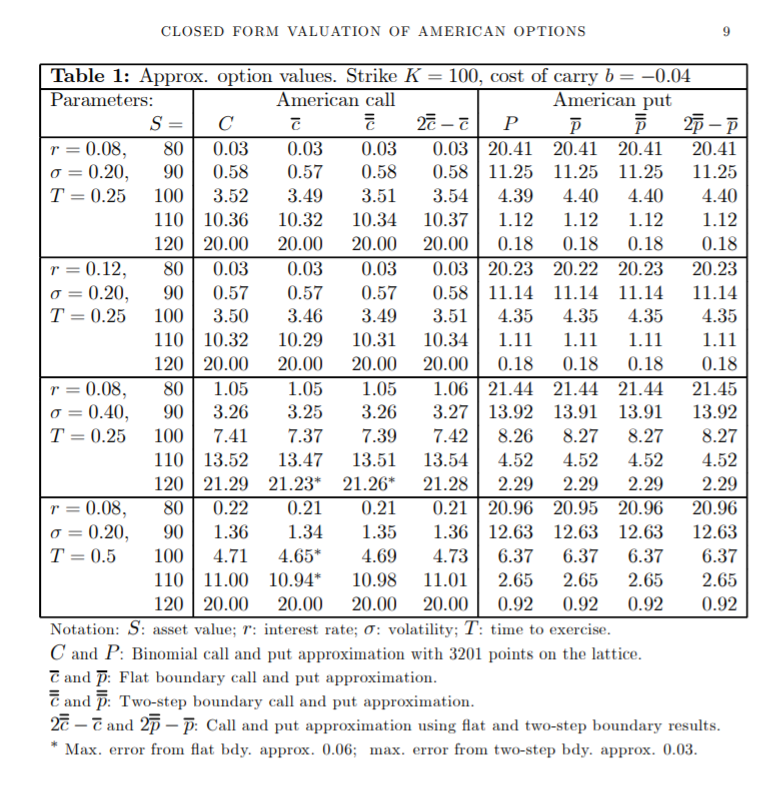